### Importamos los paquetes necesarios

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier

from sklearn import tree

from IPython.display import Image  

from skopt import gp_minimize
from skopt.space import Categorical, Dimension, Integer, Real  # noqa

import warnings
warnings.filterwarnings('ignore')

In [2]:
random_state = 7777

### Una funcion de regalo para hacer prunning

In [3]:
from sklearn.tree._tree import TREE_LEAF

def prune_tree(inner_tree, umbral=0.5, index=0):
    if(inner_tree.children_left[index] == TREE_LEAF):
        cant_clase_1 = inner_tree.value[index][0][0]
        cant_clase_2 = inner_tree.value[index][0][1]
        total = cant_clase_1+cant_clase_2
        p_clase_2 = cant_clase_2/total
        if(p_clase_2 > umbral):
            return 1
        else:
            return 0
    else:
        left_class = prune_tree(inner_tree, umbral=umbral, index=inner_tree.children_left[index])
        right_class = prune_tree(inner_tree, umbral=umbral, index=inner_tree.children_right[index])
        if((left_class>=0)&(right_class>=0) & (left_class == right_class)):
            inner_tree.children_left[index] = TREE_LEAF
            inner_tree.children_right[index] = TREE_LEAF
            return left_class
        else:
            return -1
    
#prune_tree(clf.tree_, 0.111111112)

### Adicionamos un dataset con la disponibilidad

In [4]:
directorio_data = '../data/'
dataset_completo_file = directorio_data + 'beer_reviews.csv'
df_extra_info_dataset = pd.read_csv(dataset_completo_file)[['beer_beerid', 'review_time']]
df_extra_info_dataset['review_date'] = pd.to_datetime(pd.to_datetime(df_extra_info_dataset['review_time'],unit='s')).dt.date
df_extra_info_dataset.head()
df_extra_info_dataset = df_extra_info_dataset.groupby(['beer_beerid']).agg(
    min_review_date = pd.NamedAgg(column='review_date', aggfunc='min'),
    max_review_date = pd.NamedAgg(column='review_date', aggfunc='max')
).reset_index()

df_extra_info_dataset['disponibilidad'] = (df_extra_info_dataset['max_review_date'] - df_extra_info_dataset['min_review_date']) / np.timedelta64(1, 'D')

df_extra_info_dataset.head()

,beer_beerid,min_review_date,max_review_date,disponibilidad
0,3,2002-04-17,2003-03-17,334.0
1,4,2002-04-05,2005-03-21,1081.0
2,5,2001-07-08,2012-01-01,3829.0
3,6,2001-03-02,2012-01-02,3958.0
4,7,2001-10-19,2011-12-31,3725.0


## Zona de Feature engineering y filtrado

Pueden agregar aquí todas las funciones que deseen, pero:
* La función debe recibir un dataframe como parámetro y devolver un dataframe como parámetro
* La cantidad de filas del dataframe de entrada no puede ser diferente que la cantidad de filas del dataframe de salida

Tambien es  importante que las funciones que quieran utilizar estén en el array "funciones"
El orden es importante, ya que si una función (digamos f2) utiliza columnas generadas por otra función (digamos f1) entonces f1 debe aparecer primero que f2 en el array

El último array (columnas) es el que indica cuáles de todas las columnas que están disponibles (originales + agregadas) son las que alimentarán finalmente el modelo

In [5]:
def feature_engineering_agregar_dispnibilidad(df):
    df_output = df.copy()
    
    df_output = pd.merge(left=df_output, right=df_extra_info_dataset, left_on='beer_beerid', right_on='beer_beerid')
    
    return df_output

def feature_engineering_total(df):
    df_output = df.copy()

    df_output['review_total'] = (df['review_overall'] + df['review_aroma'] + df['review_appearance'] + df['review_palate'] + df['review_taste'])
    
    return df_output

def feature_engineering_relacion_al_overall(df):
    df_output = df.copy()
    
    df_output['relacion_overall_aroma'] = df_output['review_aroma']/df['review_overall']
    df_output['relacion_overall_palate'] = df_output['review_palate']/df['review_overall']
    
    return df_output

def filtering_1(df):
    df_output = df
    return df_output


funciones = [
    "feature_engineering_agregar_dispnibilidad",
    "feature_engineering_total",
    "feature_engineering_relacion_al_overall"
]

# Las columnas que deseamos mantener
columnas = [
    "review_overall",
    #"review_aroma",
    #"review_appearance",
    "review_palate",
    #"review_taste",
    "beer_abv",
    "review_total",
    'relacion_overall_aroma',
    'relacion_overall_palate',
    'disponibilidad'
]

### Carga de datos

In [6]:
directorio_data = '../data/'

x_training_file = directorio_data + 'x_traininig.csv'
y_training_file = directorio_data + 'y_traininig.csv'

x_testing_file = directorio_data + 'x_testing.csv'
y_testing_file = directorio_data + 'y_testing.csv'

In [7]:
df_x_training_validacion = pd.read_csv(x_training_file)
df_y_training_validacion = pd.read_csv(y_training_file)

df_x_testing = pd.read_csv(x_testing_file)
df_y_testing = pd.read_csv(y_testing_file)

### Aplicamos las funciones de feature engineering a los datasets de training y testing

In [8]:
df_x_training_validacion_fe = df_x_training_validacion.copy()
df_x_testing_fe = df_x_testing.copy()

for funcion in funciones:
    #¿es una función de feature engineering?
    if(funcion.startswith('feature_engineering_')):
       long_inicial_x_training_fe = len(df_x_training_validacion_fe)
       df_x_training_validacion_fe = locals()[funcion](df_x_training_validacion_fe)
       long_final_x_training_fe = len(df_x_training_validacion_fe)
       if(long_inicial_x_training_fe != long_final_x_training_fe):
           raise Exception("Se están eliminando registros del dataset de training en una funcion de feature engineering")
       
       
       long_inicial_x_testing_fe = len(df_x_testing_fe)
       df_x_testing_fe = locals()[funcion](df_x_testing_fe)
       long_final_x_testing_fe = len(df_x_testing_fe)
       if(long_inicial_x_testing_fe != long_final_x_testing_fe):
           raise Exception("Se están eliminando registros del dataset de testing en una funcion de feature engineering")
        
    #¿es una función de filtrado?
    elif(funcion.startswith('filtering_')):
       df_x_training_validacion_fe = locals()[funcion](df_x_training_validacion_fe)
           

In [9]:
df_x_training_validacion_fe.head()

,beer_beerid,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,min_review_date,max_review_date,disponibilidad,review_total,relacion_overall_aroma,relacion_overall_palate
0,7377,3.250000,3.000,3.000000,3.250000,3.250000,5.2,2003-04-20,2006-02-27,1044.0,15.750000,0.923077,1.000000
1,21753,4.150000,4.175,4.400000,4.125000,4.125000,4.2,2005-01-30,2011-07-05,2347.0,20.975000,1.006024,0.993976
2,5330,4.000000,4.000,4.000000,4.000000,4.500000,8.0,2002-08-07,2002-08-07,0.0,20.500000,1.000000,1.000000
3,67188,4.125000,3.875,3.750000,4.125000,4.000000,6.0,2011-03-14,2011-04-19,36.0,19.875000,0.939394,1.000000
4,16542,4.208333,3.750,4.333333,4.083333,4.083333,6.7,2004-04-26,2011-01-26,2466.0,20.458333,0.891089,0.970297


In [10]:
df_x_testing_fe.head()

,beer_beerid,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,min_review_date,max_review_date,disponibilidad,review_total,relacion_overall_aroma,relacion_overall_palate
0,10364,3.751534,3.030675,3.257669,3.266871,3.401840,4.6,2003-07-04,2012-01-08,3110.0,16.708589,0.807850,0.870809
1,18518,3.818182,3.727273,3.545455,3.681818,3.818182,7.0,2004-07-05,2011-11-24,2698.0,18.590909,0.976190,0.964286
2,16278,3.071429,2.928571,3.500000,3.214286,3.142857,4.0,2005-11-04,2009-01-02,1155.0,15.857143,0.953488,1.046512
3,11087,2.625000,2.750000,3.250000,3.375000,2.750000,5.0,2005-02-21,2006-07-10,504.0,14.750000,1.047619,1.285714
4,17042,4.000000,3.500000,3.000000,4.000000,4.000000,4.8,2004-04-10,2004-04-10,0.0,18.500000,0.875000,1.000000


### Funcion a maximizar con optimización bayesiana

In [11]:
def cv_con_umbral_de_corte(params):
    umbral_corte = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]
    
    X = df_x_training_validacion_tmp
    y = df_y_training_validacion
    criterion='gini'
    clf = DecisionTreeClassifier(
                criterion = criterion,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=1
            )

    # 5-fold cross validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    def metrica_de_negocio(clf, X, y):
        y_pred = clf.predict_proba(X)
        df_y_pred_proba = pd.DataFrame(y_pred, columns = ['NO_prob', 'SI_prob'])
        df_y_pred_proba['prediccion'] = 'NO'
        df_y_pred_proba.loc[df_y_pred_proba['SI_prob']>umbral_corte,'prediccion'] = 'SI'
        
        cm = confusion_matrix(y, df_y_pred_proba['prediccion'], labels=['SI', 'NO'])
        true_positives = cm[0,0]
        true_negatives = cm[1,1]
        false_positives = cm[1, 0]
        false_negatives = cm[0,1]
        metrica_negocio = ((4000*true_positives) - (500*false_positives))/(true_positives + false_negatives)
        
        return {
            'metrica_negocio': metrica_negocio,
        }
    
    scores = cross_validate(clf, X, y, scoring=metrica_de_negocio, cv=cv)
    
    resultados = {
        'metrica negocio':         round(np.mean(scores['test_metrica_negocio']),2)
    }
    return -resultados['metrica negocio']

### La zona de procesamiento

[1, [0.1042759991723782, 52, 8809, 8711], 0.0]
[2, [0.10588974211893269, 52, 9007, 6140], 0.0]
[3, [0.10964169070397224, 44, 6029, 2733], 777.79]
[4, [0.11253308201099622, 30, 7223, 7869], 0.0]
[5, [0.10281642852188151, 18, 1670, 8412], 0.0]
[6, [0.11702949212719985, 29, 2736, 8162], 0.0]
[7, [0.1111014412174576, 47, 7507, 980], 1483.7]
[8, [0.11592427559085738, 25, 1885, 6687], 0.0]
[9, [0.11697038348605615, 8, 9104, 1900], 1192.83]
[10, [0.11395457979170637, 26, 356, 375], 1705.72]
[11, [0.1, 1, 10000, 1], 1403.37]
[12, [0.12, 100, 10000, 1], 1413.11]
[13, [0.12, 100, 2, 1], 843.8]
[14, [0.12, 1, 2, 1], 1403.37]
[15, [0.12, 36, 10000, 1], 1413.11]
[16, [0.1, 43, 897, 1], 1571.78]
[17, [0.1, 28, 2, 1098], 1505.2]
[18, [0.1, 27, 3418, 169], 1313.32]
[19, [0.1, 1, 10000, 1], 1403.37]
[20, [0.12, 71, 6508, 1], 1413.11]
[21, [0.12, 41, 2, 1], 843.8]
[22, [0.10846469406437183, 1, 2, 1], 1403.37]
[23, [0.1, 1, 10000, 854], 1504.47]
[24, [0.1, 1, 10000, 862], 1496.91]
[25, [0.104294187770816

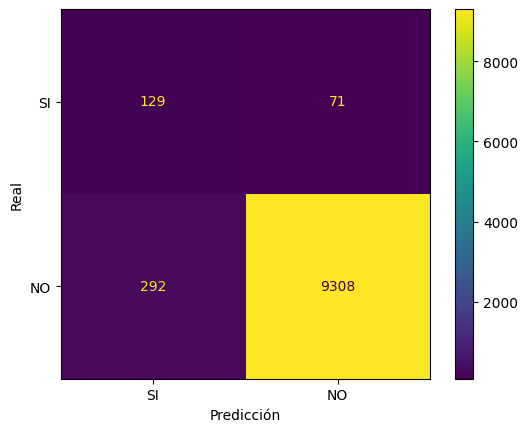

Metrica del negocio: $ 1850.0
                  features  importance
6           disponibilidad    0.858841
1            review_palate    0.073351
3             review_total    0.035433
4   relacion_overall_aroma    0.022470
2                 beer_abv    0.007424
5  relacion_overall_palate    0.001453
0           review_overall    0.001029


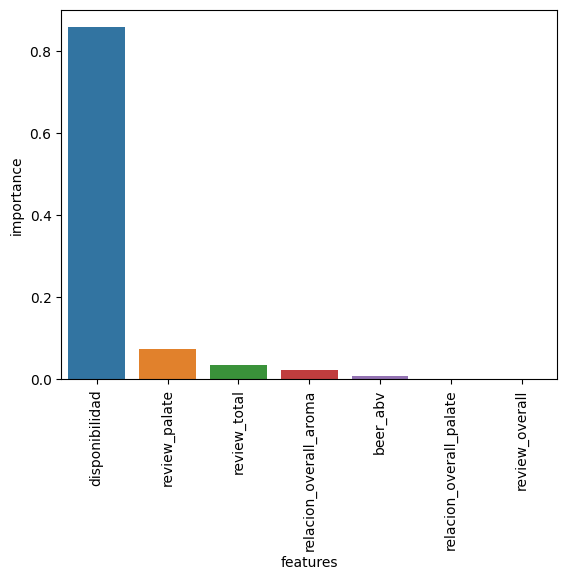

In [12]:
#Adaptamos los datasets de training y testing para contener solo las columnas deseadas
df_x_training_validacion_tmp = df_x_training_validacion_fe[columnas]
df_x_testing_tmp = df_x_testing_fe[columnas]


#Definimos el espacio de busqueda de hiper-parametros
space  = [
    Real(0.10, 0.12, name='umbral_corte'),
    Integer(1, 100, name = 'max_depth'),
    Integer(2, 10000, name = 'min_samples_split'), 
    Integer(1, 10000, name = 'min_samples_leaf')
]


#LA función de minimización
res = gp_minimize(cv_con_umbral_de_corte,                  # the function to minimize
                  space,     # the bounds on each dimension of x
                  n_initial_points = 10,
                  n_calls=100,         # the number of evaluations of f including at x0
                  n_random_starts=10,  # the number of random initialization points
                  random_state= random_state,
                  acq_func = "LCB",
                  callback = lambda res: print([
                          len(res.func_vals), 
                          res.x_iters[len(res.x_iters)-1], 
                          -res.func_vals[len(res.func_vals)-1]
                      ])
                 )
#imprimimos los mejores hiperparametros y la funcion de ganancia
print([res.x, -res.fun])

#Establecemos los mejores paámetros
punto_de_corte = res.x[0]
max_depth = res.x[1]
min_samples_split = res.x[2]
min_samples_leaf = res.x[3]

#Generamos y entrenamos el modelo con los datos de training
clf = DecisionTreeClassifier(
            criterion='gini',
            max_depth = max_depth,
            min_samples_split = min_samples_split,
            min_samples_leaf = min_samples_leaf,
            random_state = random_state
        )
_ = clf.fit(df_x_training_validacion_tmp, df_y_training_validacion)

#Realizamos la predicción con los datos de testing
y_validacion_pred = clf.predict_proba(df_x_testing_tmp)
df_y_validacion_pred_proba = pd.DataFrame(y_validacion_pred, columns = ['NO_prob', 'SI_prob'])
df_y_validacion_pred_proba['prediccion'] = 'NO'
df_y_validacion_pred_proba.loc[df_y_validacion_pred_proba['SI_prob']>punto_de_corte, 'prediccion'] = 'SI'

#mostramos la matriz de confusión
cm = confusion_matrix(df_y_testing, df_y_validacion_pred_proba['prediccion'], labels=['SI', 'NO'])
true_positives = cm[0,0]
true_negatives = cm[1,1]
false_positives = cm[1, 0]
false_negatives = cm[0,1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SI', 'NO'])
disp.plot()
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

#calculamos y mostramos la metrica del negocio
metrica_negocio = ((4000*true_positives) - (500*false_positives))/(true_positives + false_negatives)
print("Metrica del negocio: $", metrica_negocio)

#importancia de las variables
d = {'features': columnas, 'importance': clf.feature_importances_}
df = pd.DataFrame(data= d).sort_values(by=['importance'],ascending=False)
print(df)

g = sns.barplot(data=df, x="features", y="importance")
plt.setp(g.get_xticklabels(), rotation=90)
plt.show()

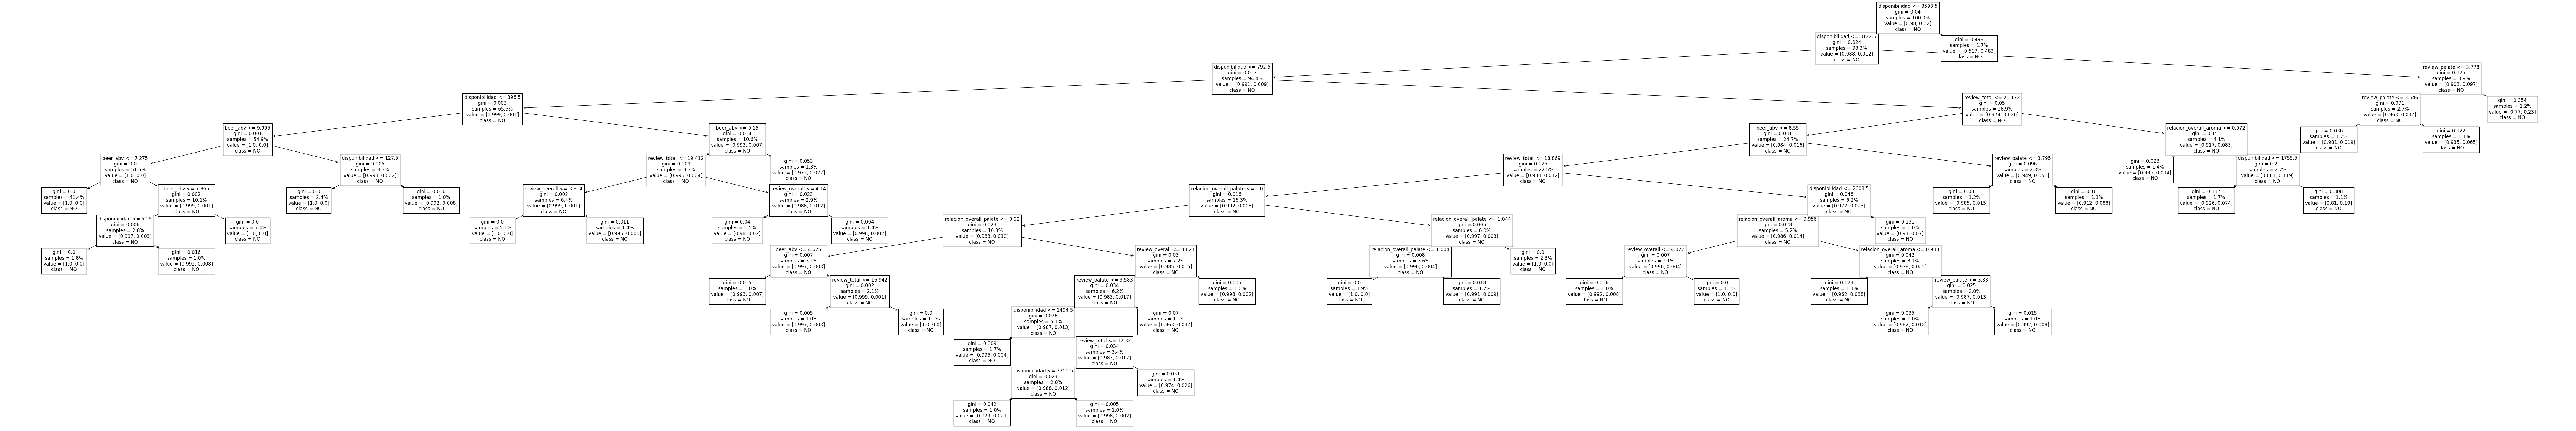

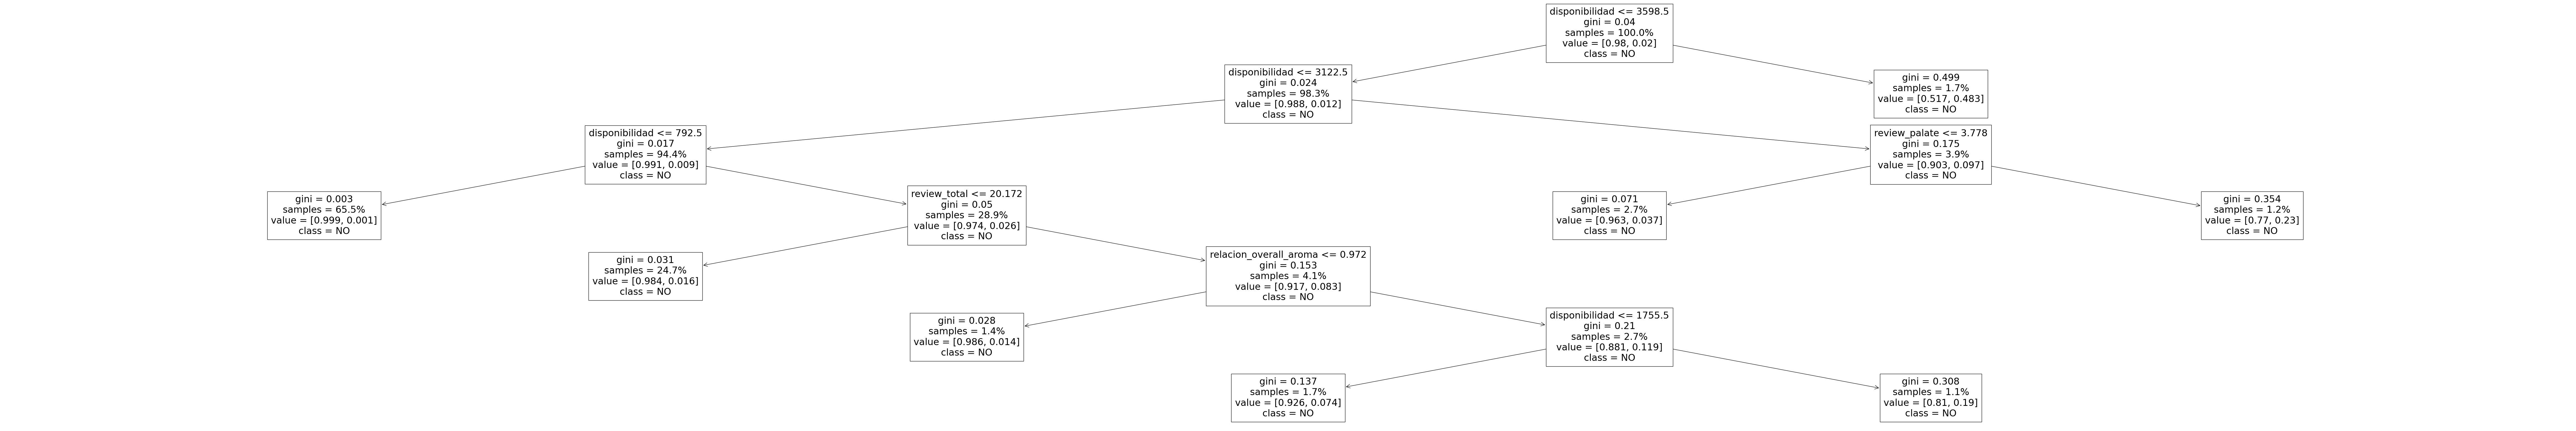

In [13]:
fig = plt.figure(figsize=(120,20))
tree.plot_tree(clf, 
                   feature_names=columnas,  
                   class_names=df_y_training_validacion['POPULAR'].unique(),
                   proportion = True,
                   filled=False)
plt.savefig('../Competencia/img/tree_final_original.png',format='png',bbox_inches = "tight", dpi=240)
prune_tree(clf.tree_, punto_de_corte)
fig = plt.figure(figsize=(120,20))
tree.plot_tree(clf, 
                   feature_names=columnas,  
                   class_names=df_y_training_validacion['POPULAR'].unique(),
                   proportion = True,
                   filled=False)
plt.savefig('../Competencia/img/tree_final_prunned.png',format='png',bbox_inches = "tight", dpi=240)